# Figures

#### Imports

In [1]:
# imports
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import os
import pooch
import ipywidgets as widgets

from pooch import HTTPDownloader
import xarray as xr
import os
from datetime import timedelta, datetime

import geoviews as gv
from geoviews import Dataset as gvDataset
import geoviews.feature as gf
from geoviews import Image as gvImage

from cartopy import crs as ccrs
from cartopy import feature as cfeature

/Users/zoubou/opt/anaconda3/envs/CMA_2023/lib/python3.11/site-packages/geoviews/operation/__init__.py:14: HoloviewsDeprecationWarning: 'ResamplingOperation' is deprecated and will be removed in version 1.18, use 'ResampleOperation2D' instead.
  from holoviews.operation.datashader import (


#### Defining `storm_repo` and `colors`

In [2]:
storm_repo = {
    
             "Sandy":{"start_date": datetime(2012, 10, 21), 
                      "end_date": datetime(2012, 10, 31),
                      "tide": "Spring",
                      "duration": 10,
                      "maxIntensity_kt": 100,
                      "maxIntensity_mb": 940,
                      "tg": {"Atlantic City, NJ": {"lat": 39.35500, "lon": -74.41800},
                            "Montauk, NY": {"lat": 40.693, "lon": -72.049},
                            "The Battery, NY": {"lat": 40.701, "lon": -74.014}},
                      
                      "tg_precise": {"Atlantic City, NJ (precise)": {"lat": 39.35500, "lon": -74.41800},
                            "Montauk, NY (precise)": {"lat": 40.693, "lon": -72.049},
                            "The Battery, NY (precise)": {"lat": 40.701, "lon": -73.75}}
                    },
              
             "Maria":{"start_date": datetime(2017, 9, 16), 
                      "end_date": datetime(2017, 10, 2),
                      "tide": "Spring",
                      "duration": 17,
                      "maxIntensity_kt": 150,
                      "maxIntensity_mb": 908,
                      "tg": {"Penuelas, PR": {"lat": 17.972, "lon": -66.762},
                            "Isabel Segunda, PR": {"lat": 18.152, "lon": -65.443},
                            "Esperanza, PR": {"lat": 18.093, "lon": -65.47},
                            "Arecibo, PR": {"lat": 18.48, "lon": -66.702},
                            "Mayaguez, PR": {"lat": 18.22, "lon": -67.16},
                            "Fajardo, PR": {"lat": 18.333, "lon": -65.633}},

                      "tg_precise": {"Penuelas, PR (precise)": {"lat": 17.4, "lon": -66.762},
                            "Isabel Segunda, PR (precise)": {"lat": 18.152, "lon": -65.443},
                            "Esperanza, PR (precise)": {"lat": 18.093, "lon": -65.47},
                            "Arecibo, PR (precise)": {"lat": 18.5, "lon": -66.702},
                            "Mayaguez, PR (precise)": {"lat": 18.22, "lon": -67.16},
                            "Fajardo, PR (precise)": {"lat": 18.333, "lon": -65.633}}
                    }, 
              
             "Ketsana":{"start_date": datetime(2009, 9, 25), 
                      "end_date": datetime(2009, 9, 30),
                      "tide": "Neap",
                      "duration": 5,
                      "maxIntensity_kt": 90,
                      "maxIntensity_mb": 955,
                      "tg": {"Malakal, Palau": {"lat": 7.33000, "lon": 134.46300},
                            "Legaspi, Philippines": {"lat": 13.15000, "lon": 123.75000},
                            "Manila, Philippines": {"lat": 14.58500 , "lon": 120.96800},
                            "Subic Bay, Philippines": {"lat": 14.76500 , "lon": 120.25200},
                            "Qui Nhon, Vietnam": {"lat": 13.77500, "lon": 109.25500}},
                      "tg_precise": {"Malakal, Palau (precise)": {"lat": 7.33000, "lon": 134.46300},
                            "Legaspi, Philippines (precise)": {"lat": 13.15000, "lon": 124.1},
                  #          "Manila, Philippines (precise)": {"lat": 14.58500 , "lon": 120.96800},
                            "Subic Bay, Philippines (precise)": {"lat": 14.76500 , "lon": 119.9},
                            "Qui Nhon, Vietnam (precise)": {"lat": 13.77500, "lon": 109.25500}}
                    }
             }

In [3]:
colors = {
    "blue": "#1f77b4",
    "orange": "#ff7f0e",
    "green": "#2ca02c",
    "red": "#d62728",
    "purple": "#9467bd",
    "brown": "#8c564b",
    "pink": "#e377c2",
    "gray": "#7f7f7f",
    "olive": "#bcbd22",
    "cyan": "#17becf"
}

#### **get_ds_for_date_range()**

In [4]:
def get_ds_for_date_range(start_date, end_date, auth=("franckprts", "hebm0LsvcHr#1N7QjYL")):
    
    # Calculate the number of days in the range
    num_days = (end_date - start_date).days + 1

    datasets = []

    for i in range(num_days):
        date_req = (start_date + timedelta(days=i)).strftime("%Y-%m-%d")

#   native     ecco_url = "https://ecco.jpl.nasa.gov/drive/files/Version4/Release4b/native/daily/SSH/"
        ecco_url = "https://ecco.jpl.nasa.gov/drive/files/Version4/Release4b/latlon/daily/SSH"
#   native     file_req = f"SEA_SURFACE_HEIGHT_day_mean_{date_req}_ECCO_V4r4b_latlon_llc0090.nc"
        file_req = f"SEA_SURFACE_HEIGHT_day_mean_{date_req}_ECCO_V4r4b_latlon_0p50deg.nc"
        
        if not os.path.exists("./data/{}".format(file_req)):
            
            fn = os.path.join(ecco_url, file_req)

            # let the downloader know the login credentials
            downloader = HTTPDownloader(auth=auth)
            downloader(url=fn, output_file="./data/{}".format(file_req), pooch=None)

            dataset = xr.open_dataset("./data/{}".format(file_req))
            datasets.append(dataset)

        else:
            dataset = xr.open_dataset("./data/{}".format(file_req))
            datasets.append(dataset)
            

    return xr.concat(datasets, dim="time")

#### **plot_area()**

In [5]:
def plot_area(lat_min, lat_max, lon_min, lon_max, ds, event:str, location_dict:dict, title_prefix:str, save_fig=True, plot_fig=True):
    # Slice the dataset based on latitude and longitude
    ds_zoom = ds.sel(latitude=slice(lat_min, lat_max), longitude=slice(lon_min, lon_max))

    tg = location_dict[event]["tg"]
    tg_precise = location_dict[event]["tg_precise"]

    # Set up the plot
    fig = plt.figure(figsize=(10, 8))
    ax = plt.axes(projection=ccrs.PlateCarree())

    # Select a specific time slice, for example, the first time step
    time_slice = 0
    ds_time_slice = ds_zoom.isel(time=time_slice)

    # Plot the data using pcolormesh
    ds_time_slice["SSH"].plot.pcolormesh(ax=ax, x="longitude", y="latitude", transform=ccrs.PlateCarree())

    # Add triangle markers for the provided locations in tg
    for (_, (location, coords)), color in zip(enumerate(tg.items()), colors):
        lat, lon = coords["lat"], coords["lon"]
        ax.plot(lon, lat, marker="^", color=color, markersize=8, transform=ccrs.PlateCarree(), label=location)

    if tg_precise is not None:
        for (_, (location, coords)), color in zip(enumerate(tg_precise.items()), colors):
                lat, lon = coords["lat"], coords["lon"]
                ax.plot(lon, lat, marker="*", color=color, markersize=8, transform=ccrs.PlateCarree(), label=location)

    # Add legend
    ax.legend()

    # Add map features
    ax.coastlines()
    ax.gridlines(draw_labels=True)

    # Add a title
    plt.title(f"ECCO SSH and TG locations for {event}")

    # Show the plot
    if save_fig:
        figure_dir = './figures/'
        os.makedirs(figure_dir, exist_ok=True)

        plot_filename = f'map_{title_prefix}{event}.png'
        plt.savefig(os.path.join(figure_dir, plot_filename))
    if plot_fig: plt.show()
    else: plt.close()

#### **plot_time_series()**

In [6]:
def plot_time_series(data_dict, event, baseline_dict=True, save_fig=True, plot_fig=True):
    
    event_data = data_dict.get(event, None)
    if event_data is None:
        print(f"Event '{event}' not found in the dictionary.")
        return

    # Create a plot for the time series
    plt.figure(figsize=(12, 6))

    for idx, (location, values) in enumerate(event_data.items()):
        # Assuming values is a NumPy array or a list
        time = range(len(values))

        bl1 = baseline_dict[event][location]["bl1"]
        bl2 = baseline_dict[event][location]["bl2"]

        # Plot bl1 as a point (disconnected from the time series)
        plt.scatter(-1, bl1, color=colors[list(colors.keys())[idx]], label=f"{location} - bl1", marker="*")

        # Plot the time series
        plt.plot(time, values, color=colors[list(colors.keys())[idx]], label=f"{location} - Time Series")

        # Plot bl2 as a point (disconnected from the time series)
        plt.scatter(len(time), bl2, color=colors[list(colors.keys())[idx]], label=f"{location} - bl2", marker="*")


    # Set plot properties
    plt.xlabel("Time (days)")
    plt.ylabel("Dynamic Sea Surface Height (SSH) anomaly [m]")
    plt.title(f"Time Series for Event: {event}")
    plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
    plt.grid(True)

    if save_fig:
        figure_dir = './figures/'
        os.makedirs(figure_dir, exist_ok=True)

        plot_filename = f'timeseries_{event}.png'
        plt.savefig(os.path.join(figure_dir, plot_filename))
    if plot_fig: plt.show()
    else: plt.close()

#### **get_baseline_date()**

In [7]:
def get_baseline_date(ref_date, date_meaning):
    
    if date_meaning == "start":
        
        # Get the date 2 months prior to ref_date
        bound1 = ref_date - timedelta(days=60)
        # Get the date 1 month prior to ref_date
        bound2 = ref_date - timedelta(days=30)
        
        
    elif date_meaning == "end":
        # Get the date 1 month post ref_date
        bound1 = ref_date + timedelta(days=30)
        # Get the date 2 months after ref_date
        bound2 = ref_date + timedelta(days=60)
    else:
        raise ValueError("Invalid date_meaning. Use 'start' or 'end'.")

    return bound1, bound2
    
    

## Ploting

#### Getting the dict ready

Now that we have the location and timeframe of the event, we can loop over them to extract the SSH per location over the whole timeframe

In [8]:
# Init a dict where the data for all event / locaiton are stored 

## At the lowest level, the the dict ds_allLoc_allEvent will only contain the 
## data of a given event (timewise), for a precise location (nearest - we use 
## the tg_precise for sampling the SSH)


doingBaselines = True 

ds_allLoc_allEvent = {} # store the ds
ar_allLoc_allEvent = {} # just store the array
bl_allLoc_allEvent = {} # store the baseline arrays

for event in storm_repo.keys():   
#for event in ["Sandy"]:   

    print("\ndoing: {}".format(event))
    
    start_date = storm_repo[event]["start_date"]
    end_date   = storm_repo[event]["end_date"]

    ds = get_ds_for_date_range(start_date, end_date)

    if doingBaselines:
        b1_start, b1_end = get_baseline_date(start_date, "start")
        b2_start, b2_end = get_baseline_date(end_date, "end")

        ds_baseline_1 =  get_ds_for_date_range(b1_start, b1_end)
        ds_baseline_2 =  get_ds_for_date_range(b2_start, b2_end)
    
    ds_loc = {}
    ar_loc = {}
    bl_loc = {}
    
    for loc in storm_repo[event]["tg_precise"].keys():
        
        print("—— {}\n\tlat: {}\n\tlon: {}".format(loc, storm_repo[event]["tg_precise"][loc]["lat"], storm_repo[event]["tg_precise"][loc]["lon"]))
 
        # Fist we deal with the data of the event 
        tmp = ds.sel(
            latitude  = storm_repo[event]["tg_precise"][loc]["lat"],
            longitude = storm_repo[event]["tg_precise"][loc]["lon"], 
            method='nearest')

        ds_loc[loc[:-10]] = tmp
        ar_loc[loc[:-10]] = tmp["SSH"].values

        if doingBaselines: 
            tmp_bl1 = ds_baseline_1.sel(
                latitude  = storm_repo[event]["tg_precise"][loc]["lat"],
                longitude = storm_repo[event]["tg_precise"][loc]["lon"], 
                method='nearest')

            bl_loc[loc[:-10]] = tmp_bl1["SSH"].values

            tmp_bl2 = ds_baseline_2.sel(
                latitude  = storm_repo[event]["tg_precise"][loc]["lat"],
                longitude = storm_repo[event]["tg_precise"][loc]["lon"], 
                method='nearest')

            bl_loc[loc[:-10]]= {}
            
            bl_loc[loc[:-10]]["values_bl1"] = tmp_bl1["SSH"].values
            bl_loc[loc[:-10]]["values_bl2"] = tmp_bl2["SSH"].values
            bl_loc[loc[:-10]]["bl1"]        = tmp_bl1["SSH"].values.mean()
            bl_loc[loc[:-10]]["bl2"]        = tmp_bl2["SSH"].values.mean()

    
    ds_allLoc_allEvent[event] = ds_loc
    ar_allLoc_allEvent[event] = ar_loc
    bl_allLoc_allEvent[event] = bl_loc   




doing: Sandy
—— Atlantic City, NJ (precise)
	lat: 39.355
	lon: -74.418
—— Montauk, NY (precise)
	lat: 40.693
	lon: -72.049
—— The Battery, NY (precise)
	lat: 40.701
	lon: -73.75

doing: Maria
—— Penuelas, PR (precise)
	lat: 17.4
	lon: -66.762
—— Isabel Segunda, PR (precise)
	lat: 18.152
	lon: -65.443
—— Esperanza, PR (precise)
	lat: 18.093
	lon: -65.47
—— Arecibo, PR (precise)
	lat: 18.5
	lon: -66.702
—— Mayaguez, PR (precise)
	lat: 18.22
	lon: -67.16
—— Fajardo, PR (precise)
	lat: 18.333
	lon: -65.633

doing: Ketsana
—— Malakal, Palau (precise)
	lat: 7.33
	lon: 134.463
—— Legaspi, Philippines (precise)
	lat: 13.15
	lon: 124.1
—— Subic Bay, Philippines (precise)
	lat: 14.765
	lon: 119.9
—— Qui Nhon, Vietnam (precise)
	lat: 13.775
	lon: 109.255


In [9]:
#import json

#with open('./saved_dict/ds_allLoc_allEvent.txt', 'w') as convert_file:
#     convert_file.write(json.dumps(ds_allLoc_allEvent))
        
#with open('./saved_dict/ar_allLoc_allEvent.txt', 'w') as convert_file:
#     convert_file.write(json.dumps(ar_allLoc_allEvent))
        
#with open('./saved_dict/bl_allLoc_allEvent.txt', 'w') as convert_file:
#     convert_file.write(json.dumps(bl_allLoc_allEvent))
        

#### Ploting

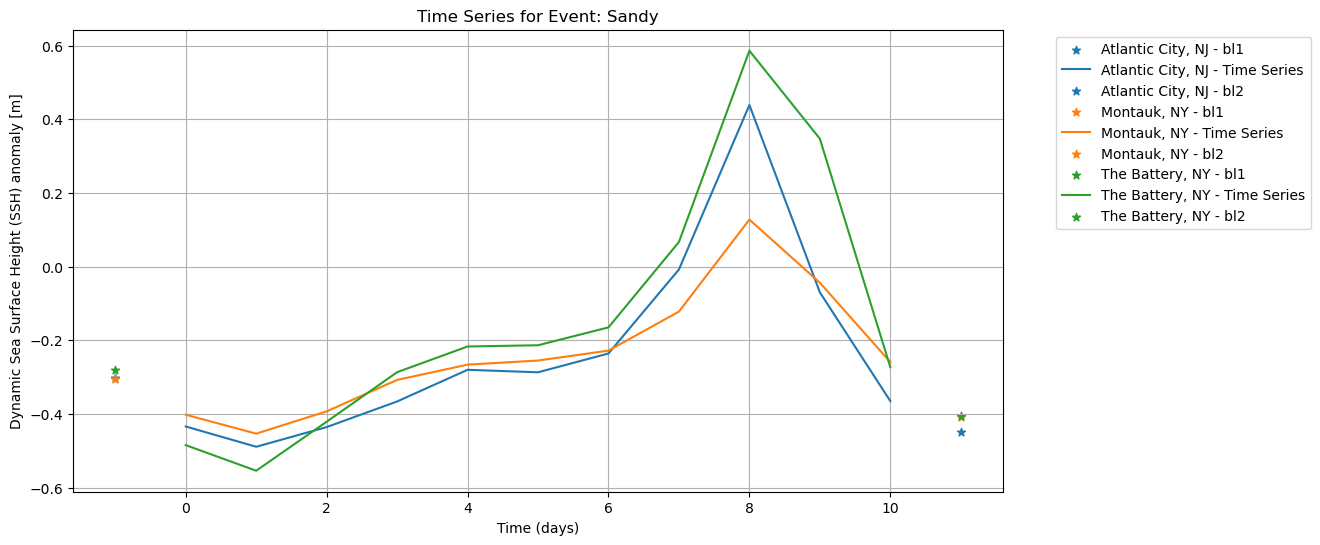

In [18]:
event = "Sandy"
plot_time_series(ar_allLoc_allEvent, event, baseline_dict = bl_allLoc_allEvent, save_fig=True, plot_fig=True)

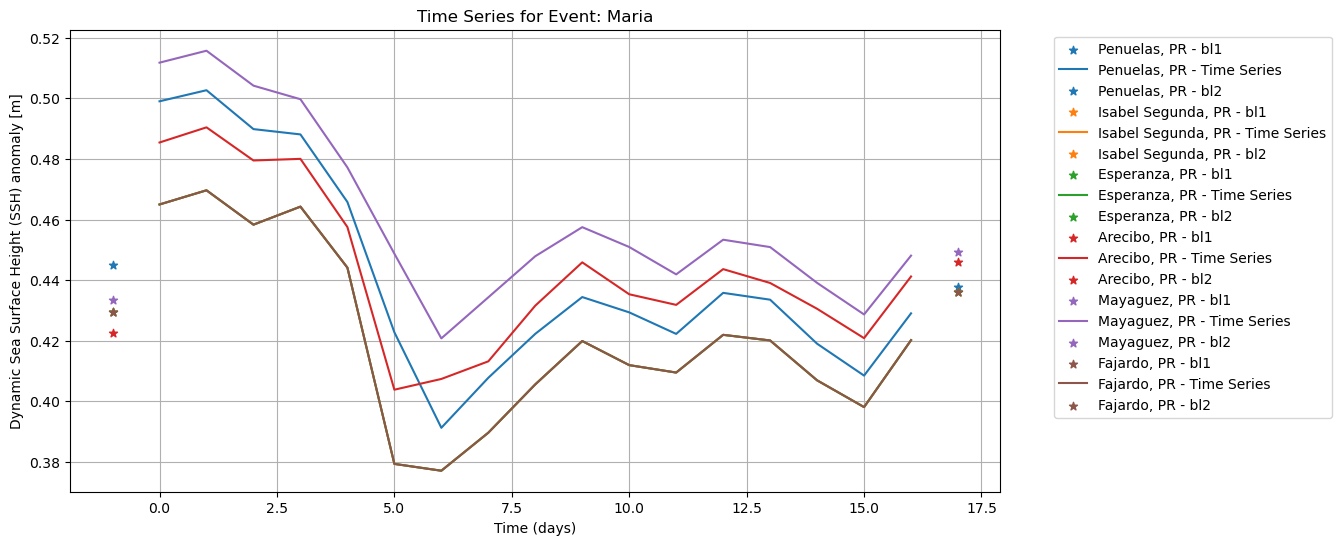

In [19]:
event = "Maria"
plot_time_series(ar_allLoc_allEvent, event, baseline_dict = bl_allLoc_allEvent, save_fig=True, plot_fig=True)

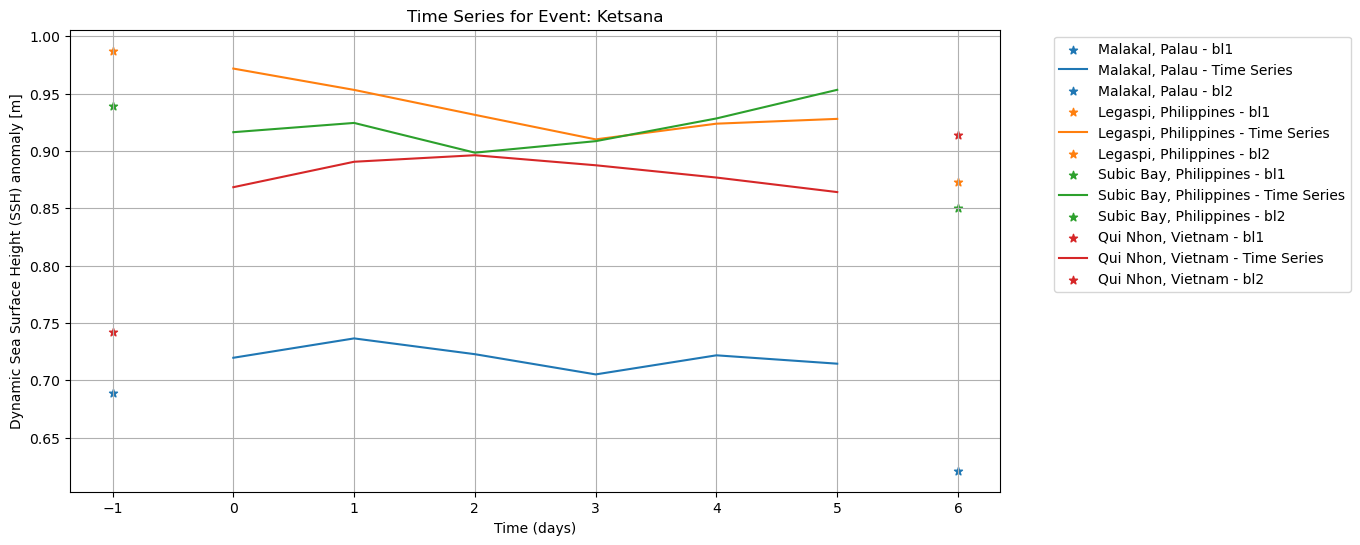

In [20]:
event = "Ketsana"
plot_time_series(ar_allLoc_allEvent, event, baseline_dict = bl_allLoc_allEvent, save_fig=True, plot_fig=True)

## Exploring the map for cell of ocean next to the gauge
stars are the choosen location, triangle are the exact tidal gauge location

In [15]:
storm_repo["Sandy"]["tg_precise"]

{'Atlantic City, NJ (precise)': {'lat': 39.355, 'lon': -74.418},
 'Montauk, NY (precise)': {'lat': 40.693, 'lon': -72.049},
 'The Battery, NY (precise)': {'lat': 40.701, 'lon': -73.75}}

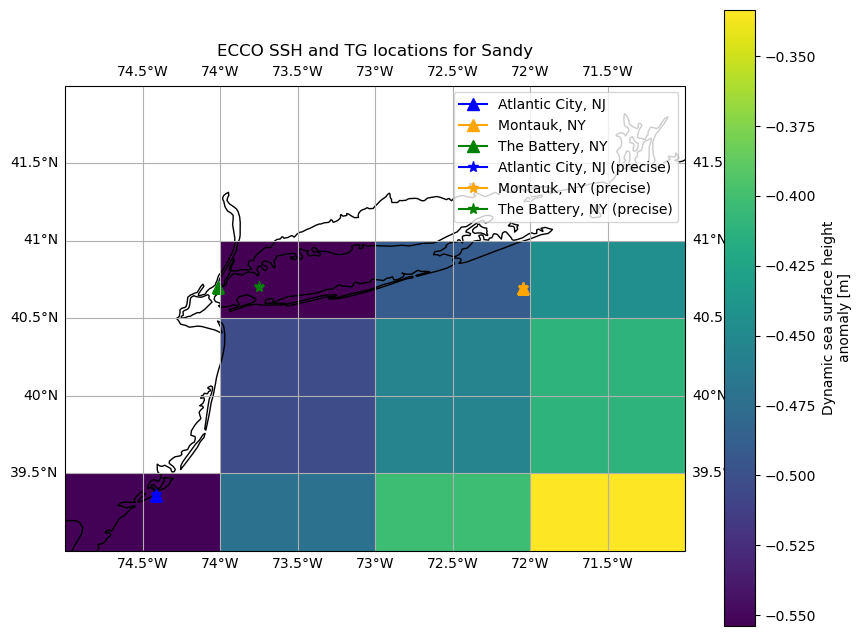

In [27]:
lat_min, lat_max = 39.0, 42.0
lon_min, lon_max = -75.0, -71.0

plot_area(lat_min, lat_max, lon_min, lon_max, 
          ds=ds, 
          event="Sandy", 
          location_dict=storm_repo, 
          title_prefix="", 
          save_fig=True, plot_fig=True)

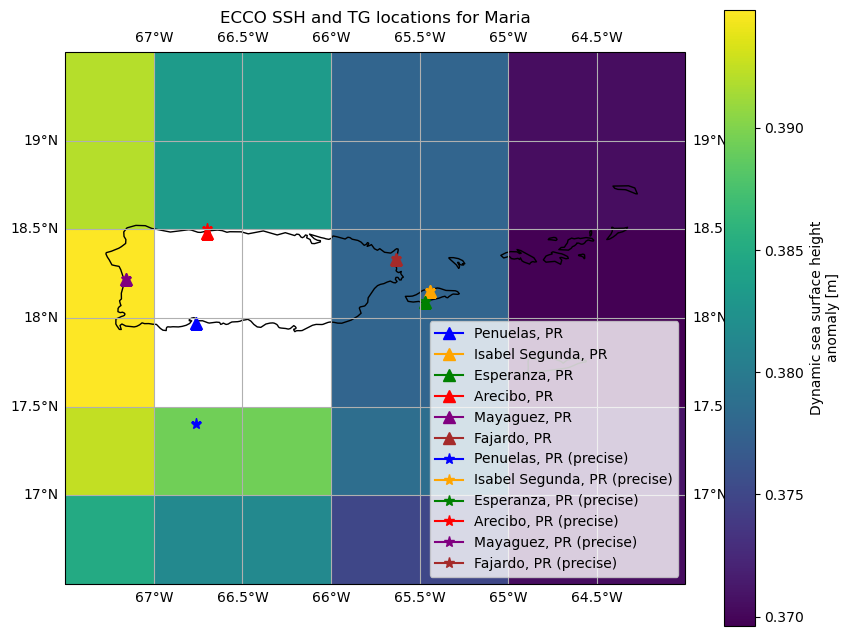

In [24]:
lat_min, lat_max = 16.5, 19.5
lon_min, lon_max = -67.5, -64.0

plot_area(lat_min, lat_max, lon_min, lon_max, 
          ds=ds, 
          event="Maria", 
          location_dict=storm_repo, 
          title_prefix="", 
          save_fig=True, plot_fig=True)

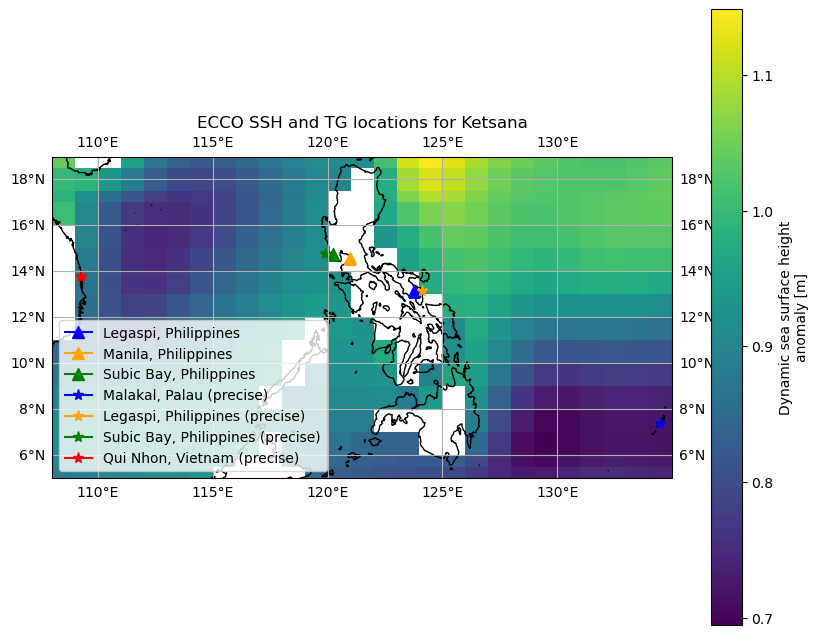

In [41]:
lat_min, lat_max = 5.0, 19.0
lon_min, lon_max = 108.0, 135.0

plot_area(lat_min, lat_max, lon_min, lon_max, 
          ds=ds, 
          event="Ketsana", 
          location_dict=storm_repo, 
          title_prefix="", 
          save_fig=True, plot_fig=True)

In [46]:
lat_min, lat_max = 12.0, 16.0
lon_min, lon_max = 118.0, 125.0

event_to_pop= ['Malakal, Palau', 'Qui Nhon, Vietnam']
event_to_pop_precise = ['Malakal, Palau (precise)', 'Qui Nhon, Vietnam (precise)']
tg_tmp = storm_repo

print(tg_tmp["Ketsana"].keys())
for event in event_to_pop:
    print(f'doing {event}')
    try: tg_tmp["Ketsana"]["tg"].pop(event)
    except: print(f"didn't find {event} for normal location")
    
for event in event_to_pop_precise:
    try: tg_tmp["Ketsana"]["tg_precise"].pop(event)
    except: print(f"didn't find {event} for precise")


print(tg_tmp["Ketsana"].keys())

dict_keys(['start_date', 'end_date', 'tide', 'duration', 'maxIntensity_kt', 'maxIntensity_mb', 'tg', 'tg_precise'])
doing Malakal, Palau
didn't find Malakal, Palau for normal location
doing Qui Nhon, Vietnam
didn't find Qui Nhon, Vietnam for normal location
dict_keys(['start_date', 'end_date', 'tide', 'duration', 'maxIntensity_kt', 'maxIntensity_mb', 'tg', 'tg_precise'])


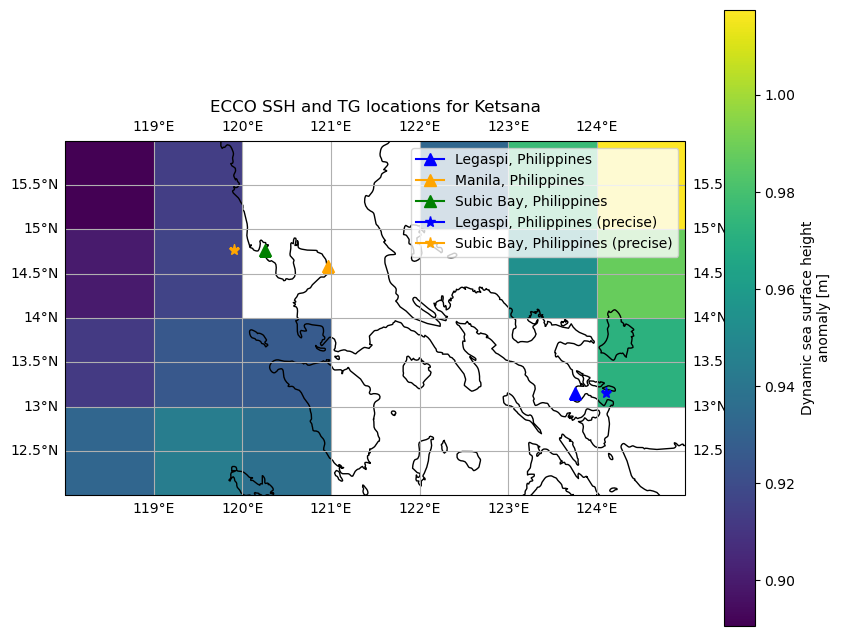

In [47]:

#plot_area(lat_min, lat_max, lon_min, lon_max, tg=tg_tmp)
plot_area(lat_min, lat_max, lon_min, lon_max, 
          ds=ds, 
          event="Ketsana", 
          location_dict=tg_tmp, 
          title_prefix="zoomed", 
          save_fig=True, plot_fig=True)

## Next

In [2]:
from pooch import HTTPDownloader
import xarray as xr
import os

def get_ds_form_URL (year = "2003", month = "03", day = "15", auth=("franckprts", "hebm0LsvcHr#1N7QjYL"))

    date_req = f"{year}-{month}-{day}"

    ecco_url = "https://ecco.jpl.nasa.gov/drive/files/Version4/Release4b/native/daily/SSH/"
    file_req = f"SEA_SURFACE_HEIGHT_day_mean_{date_req}_ECCO_V4r4b_native_llc0090.nc"
    fn = os.path.join(ecco_url,file_req)


    # let the downloader know the login credentials (Frank fill these strings in below)
    downloader = HTTPDownloader(auth=auth)
    downloader(url = fn, output_file = file_req,pooch = None)

    return xr.open_dataset(file_req)

<xarray.Dataset>
Dimensions:    (i: 90, i_g: 90, j: 90, j_g: 90, tile: 13, time: 1, nv: 2, nb: 4)
Coordinates: (12/13)
  * i          (i) int32 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
  * i_g        (i_g) int32 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
  * j          (j) int32 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
  * j_g        (j_g) int32 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
  * tile       (tile) int32 0 1 2 3 4 5 6 7 8 9 10 11 12
  * time       (time) datetime64[ns] 2003-03-15T12:00:00
    ...         ...
    YC         (tile, j, i) float32 ...
    XG         (tile, j_g, i_g) float32 ...
    YG         (tile, j_g, i_g) float32 ...
    time_bnds  (time, nv) datetime64[ns] ...
    XC_bnds    (tile, j, i, nb) float32 ...
    YC_bnds    (tile, j, i, nb) float32 ...
Dimensions without coordinates: nv, nb
Data variables:
    SSH        (time, tile, j, i) float32 ...
    SSHIBC     (time, tile, j, i) float32 ...
    SSHNOIBC   (time, tile, j, i) float32 ...
Attributes: (12/50)
    acknowledgement:              This research was carried out by the Jet Pr...
    author:                       Ou Wang and Ian Fenty
    cdm_data_type:                Grid
    comment:                      Fields provided on the curvilinear lat-lon-...
    Conventions:                  CF-1.8, ACDD-1.3
    coordinates_comment:          Note: the global 'coordinates' attribute de...
    ...                           ...
    time_coverage_duration:       P1D
    time_coverage_end:            2003-03-16T00:00:00
    time_coverage_resolution:     P1D
    time_coverage_start:          2003-03-15T00:00:00
    title:                        ECCO Sea Surface Height - Daily Mean llc90 ...
    uuid:                         4b6dcce6-7f8a-4898-a373-d498bbf208fa

### Test discord 1

In [14]:
# Input data 
year  = "2003"
month = "03"
day   = "15"

# get data from ECCO remot repo
date_req = f"{year}-{month}-{day}"

ecco_url = "https://ecco.jpl.nasa.gov/drive/files/Version4/Release4b/native/daily/SSH"
file_req = f"SEA_SURFACE_HEIGHT_day_mean_{date_req}_ECCO_V4r4b_native_llc0090.nc"

#tmp = pooch_load(ecco_url, file_req)
tmp = pooch.retrieve(ecco_url,
                     #known_hash="bbdc258e3c72ecc4bc5905be6b418638063ec0474628b534afa1141c6ea02172",
                     known_hash=None,
                     fname = file_req)
tmp

'/home/jovyan/.cache/pooch/SEA_SURFACE_HEIGHT_day_mean_2003-03-15_ECCO_V4r4b_native_llc0090.nc'

New ds

### Resolutions

Spatial resolution: .5°
Time resolution: 

In [ ]:
ds.time[-5:]

# Work we did with Gabby

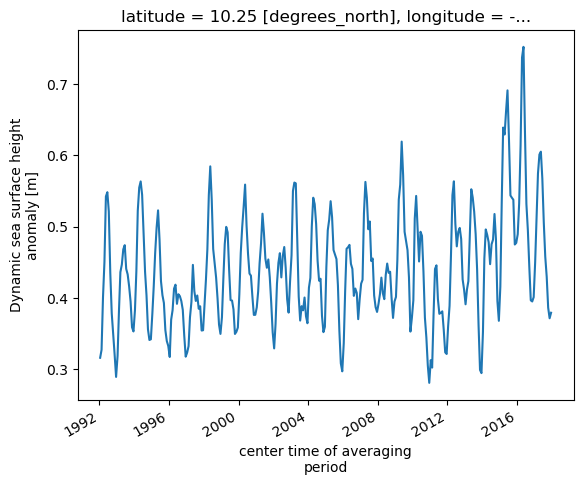

In [17]:
ds["SSH"][:, 200, 134].plot()

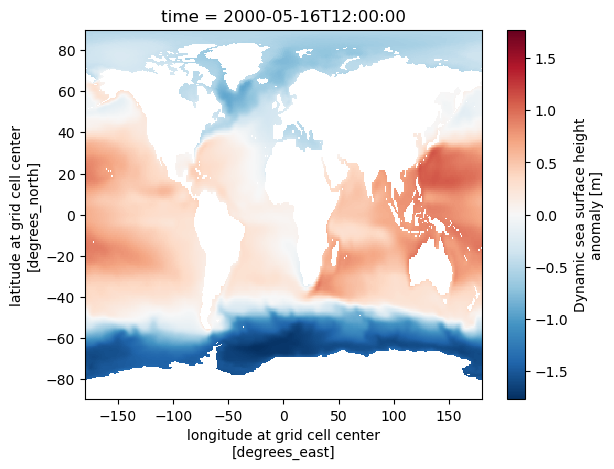

In [18]:
ds["SSH"][100, :, :].plot.pcolormesh()

In [19]:
# data source-specific functions
url_choosen = "https://uhslc.soest.hawaii.edu/data/netcdf/fast/daily/d825.nc"  # this is the link for "Cuxhaven Germany", change to your location
# example code after downloading tidal gauge data:
ds_tidal = xr.open_dataset(
    pooch.retrieve(url_choosen, known_hash=None)
)  # this is just an example, tidal gauge NetCDF file needs to be downloaded in order to load this.
ds

<xarray.Dataset>
Dimensions:         (time: 312, latitude: 360, longitude: 720, nv: 2)
Coordinates:
  * time            (time) datetime64[ns] 1992-01-16T18:00:00 ... 2017-12-16T...
  * latitude        (latitude) float32 -89.75 -89.25 -88.75 ... 89.25 89.75
  * longitude       (longitude) float32 -179.8 -179.2 -178.8 ... 179.2 179.8
    time_bnds       (time, nv) datetime64[ns] ...
    latitude_bnds   (latitude, nv) float32 ...
    longitude_bnds  (longitude, nv) float32 ...
Dimensions without coordinates: nv
Data variables:
    SSH             (time, latitude, longitude) float32 ...
    SSHIBC          (time, latitude, longitude) float32 ...
    SSHNOIBC        (time, latitude, longitude) float32 ...
Attributes: (12/57)
    acknowledgement:              This research was carried out by the Jet Pr...
    author:                       Ian Fenty and Ou Wang
    cdm_data_type:                Grid
    comment:                      Fields provided on a regular lat-lon grid. ...
    Conventions:                  CF-1.8, ACDD-1.3
    coordinates_comment:          Note: the global 'coordinates' attribute de...
    ...                           ...
    time_coverage_duration:       P1M
    time_coverage_end:            1992-02-01T00:00:00
    time_coverage_resolution:     P1M
    time_coverage_start:          1992-01-01T12:00:00
    title:                        ECCO Sea Surface Height - Monthly Mean 0.5 ...
    uuid:                         0910522c-4158-11eb-b85b-0cc47a3f5153

In [20]:
# Syntax for time slicing
# ds.SSH.sel(time=slice('2001-01-01', '2018-01-01'))


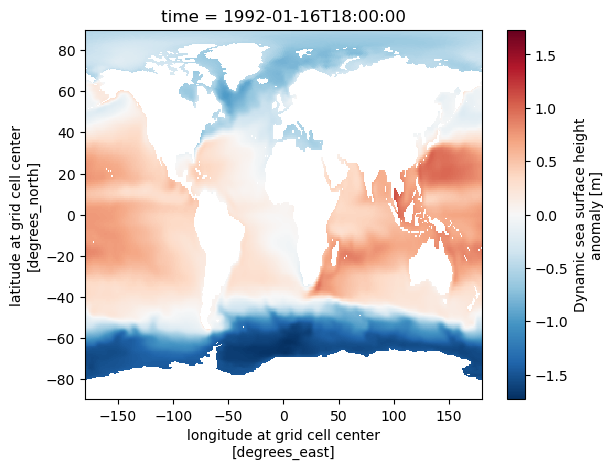

In [26]:
a = ds.SSH.sel(time='1992-01')
a.plot()

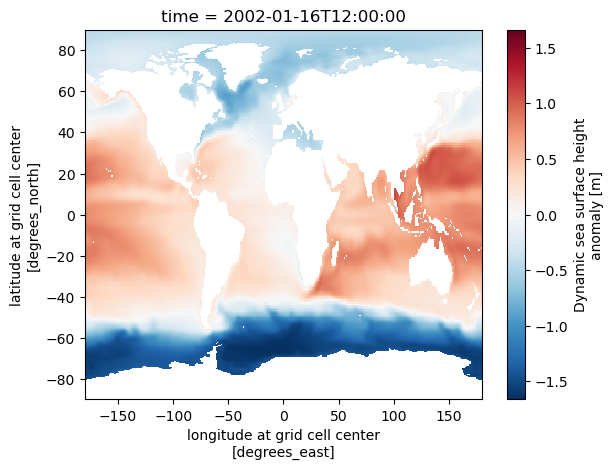

In [27]:
b = ds.SSH.sel(time='2002-01')
b.plot()

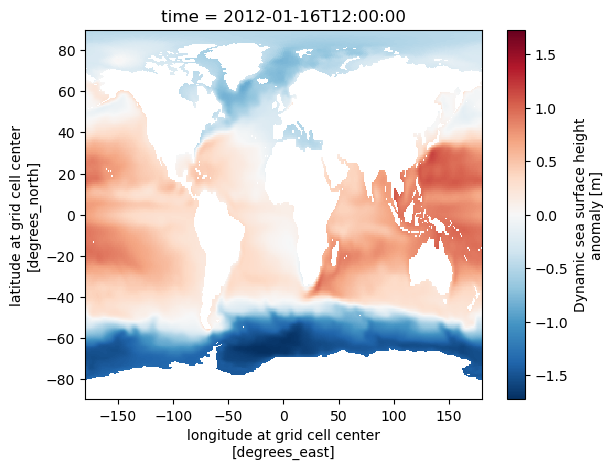

In [28]:
c = ds.SSH.sel(time='2012-01')
c.plot()

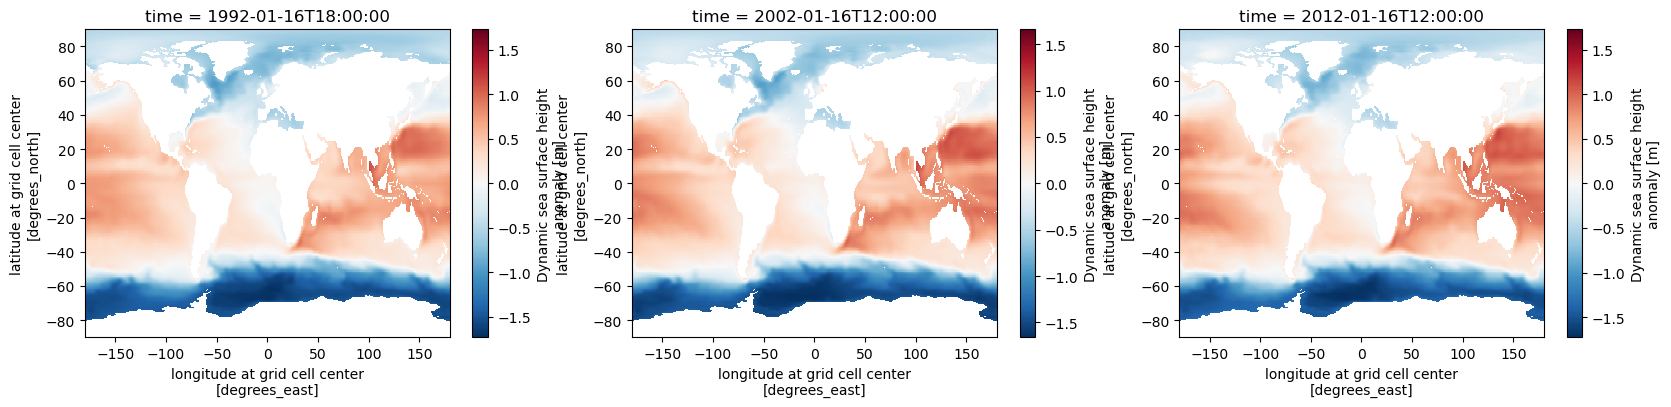

In [30]:
fig, axes = plt.subplots(ncols=3, figsize=(20, 4))
a.plot(ax=axes[0])
b.plot(ax=axes[1])
c.plot(ax=axes[2])

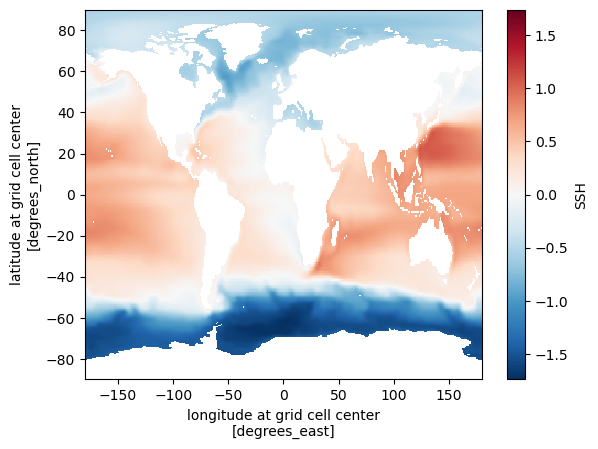

In [25]:
ds.SSH.sel(time='1992').mean(dim='time').plot()

## Q2. Plot the global mean of Sea surfaceheight as a function of time for the past 50 years or from 1960 to 2010.

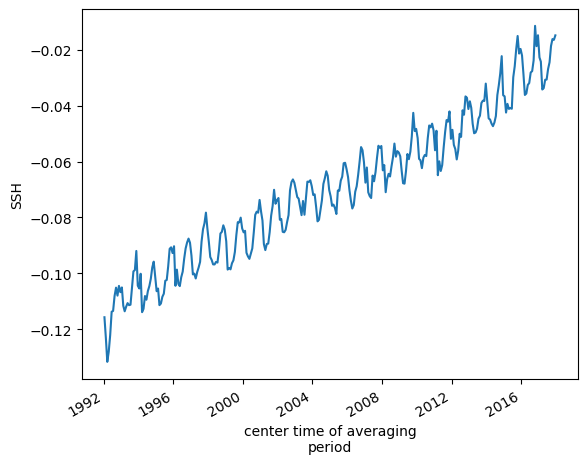

In [12]:
ds.SSH.sel(time=slice('1992','2017')).mean(['latitude', 'longitude']).plot()

## Q3. Plot an specific area of 10X10 to compare

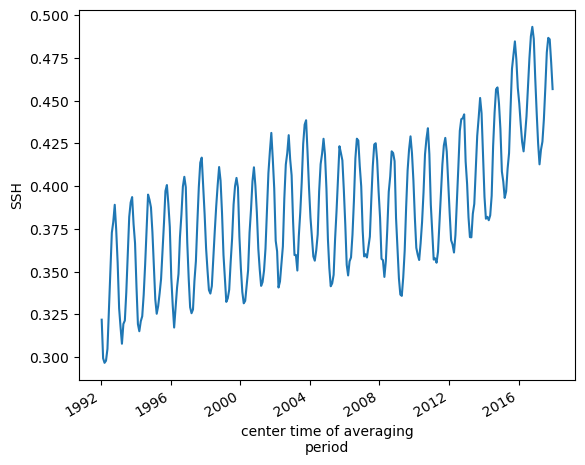

In [13]:
ds.SSH.sel(time=slice('1992','2017'), latitude=slice('20','30'), longitude=slice('-100','-90')).mean(['latitude', 'longitude']).plot()

## Q4. What other factors contribute to SSH that are not included in the ECCO model.

Answer: Biogeochemical markers, land-use, atmospheric properties, potentially Glacial Melt*** (unsure about sea ice / glacial properties)

In [14]:
## Q8. Compare Data from your model with a selected tidal gauge in your region of interest. 

In [15]:
ds_cabo = xr.open_dataset("d034.nc")
ds_cabo

<xarray.Dataset>
Dimensions:               (record_id: 1, time: 15068)
Coordinates:
  * time                  (time) datetime64[ns] 1973-06-13T12:00:00 ... 2014-...
  * record_id             (record_id) int16 340
Data variables:
    sea_level             (record_id, time) float32 ...
    lat                   (record_id) float32 ...
    lon                   (record_id) float32 ...
    station_name          (record_id) |S14 ...
    station_country       (record_id) |S6 ...
    station_country_code  (record_id) float32 ...
    uhslc_id              (record_id) int16 ...
    gloss_id              (record_id) float32 ...
    ssc_id                (record_id) |S4 ...
    last_rq_date          (record_id) datetime64[ns] ...
Attributes:
    title:                  UHSLC Fast Delivery Tide Gauge Data (daily)
    ncei_template_version:  NCEI_NetCDF_TimeSeries_Orthogonal_Template_v2.0
    featureType:            timeSeries
    Conventions:            CF-1.6, ACDD-1.3
    date_created:           2023-07-19T14:25:29Z
    publisher_name:         University of Hawaii Sea Level Center (UHSLC)
    publisher_email:        philiprt@hawaii.edu, markm@soest.hawaii.edu
    publisher_url:          http://uhslc.soest.hawaii.edu
    summary:                The UHSLC assembles and distributes the Fast Deli...
    processing_level:       Fast Delivery (FD) data undergo a level 1 quality...
    acknowledgment:         The UHSLC Fast Delivery database is supported by ...

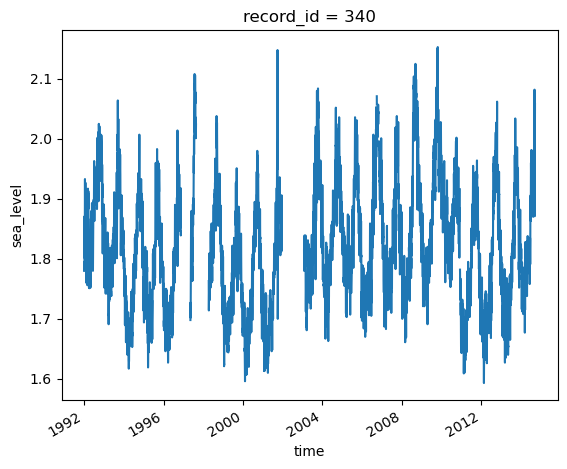

In [16]:
(ds_cabo.sea_level.sel(time=slice('1992','2017'))/1000).plot()